Hunter Bennett  
Christopher K Glass Laboratory  
Created 20171212 | Last updated 20171212
_____

Analyze ATAC seq data in strains

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess
import os
import sys
import glob
import re

# import user defined packages
sys.path.insert(0, '/home/h1bennet/scripts')
import hbUtils

# plot matplotlib plots in notebook
%matplotlib inline

In [2]:
# define path to data
datapath = {'kupffer':'/data/mm10/Kupffer/ATAC/'}

# define output directory
outdir = '/home/h1bennet/liverStrains/results/171212_ATAC/'

if not os.path.isdir(outdir):
    subprocess.call(['mkdir', outdir])

# define samples for both whole liver and kupffer
samples = {'kupffer':["aj_Kupffer_ATAC_AMLNDiet_30week_AJ3A_JSS_TDT_16_09_26",
"aj_Kupffer_ATAC_AMLNDiet_30week_AJ3B_JSS_TDT_16_09_26",
"aj_Kupffer_ATAC_ControlDiet_30week_AJ1B_JSS_TDT_16_09_26",
"aj_Kupffer_ATAC_ControlDiet_30week_AJ1C_JSS_TDT_16_09_28",
"balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3C_JSS_TDT_16_09_26",
"balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3D_JSS_TDT_16_09_28",
"balbc_Kupffer_ATAC_ControlDiet_30week_Balb1A_JSS_TDT_16_09_26",
"balbc_Kupffer_ATAC_ControlDiet_30week_Balb1B_JSS_TDT_16_09_26",
"NCoRWT_KupfferTotal_ATAC_AMLNDiet_30week_LN136C_JSS_TDT_16_09_19",
"NCoRWT_KupfferTotal_ATAC_AMLNDiet_30week_LN141A_JSS_TDT_16_09_21",
"NCoRWT_KupfferTotal_ATAC_ControlDiet_30week_LN134B_JSS_TDT_16_09_21",
"NCoRWT_KupfferTotal_ATAC_ControlDiet_30week_LN134D_JSS_TDT_16_09_21"]}

bad_samples = {'LN140D': 'cancer', 'LN136B': 'cancer', 'LN148B': 'cancer',
              'LN144A': 'cancer', 'LN144C': 'cancer', 'LN182B': 'cancer',
              'LN182B': 'cancer', 'LN203B': 'cancer', 'BALB3A': 'splenomegaly',
              'BALB4D': 'hyper-fibrosis', 'LN148B': 'cancer', 'LN166A': 'cancer'}

In [1]:
# user defined functions
def merge_peaks(dir1, dir2, outdir, dist='given', print_err=False):
    import subprocess
    import os
    # make output directory if necessary
    if not os.path.isdir(outdir): subprocess.call(["mkdir", outdir])
    # construct function call
    mP_call = ["mergePeaks"]
    mP_call.extend(['-d', dist])
    mP_call.extend([dir1 + '/optimal_peakfile.txt',
                    dir2 + '/optimal_peakfile.txt'])
    # call merge peaks
    if not os.path.isfile(outdir + '/optimal_peakfile_merge.txt'):
        print('calling mergePeaks...')
        p = subprocess.Popen(mP_call,
                            stdout = subprocess.PIPE,
                            stderr = subprocess.PIPE)
        output, err = p.communicate() #in bytes
        if print_err: print(err.decode('utf-8'))
        f = open(outdir + '/optimal_peakfile_merge.txt', 'w')
        f.write(output.decode("utf-8"))
        f.close()
    else: print('merge peaks file ' + outdir + '/optimal_peakfile_merge.txt already exists!')
    return outdir + '/optimal_peakfile_merge.txt'

def anno_peaks(dir1, dir2, outdir, dist='given', noann=False, nogene=False, print_err=False):
    import subprocess
    import os
    # call merge peaks
    mPPath = merge_peaks(dir1, dir2, outdir, dist, print_err=print_err)
    # construct function call
    aPCallList = ['annotatePeaks.pl', mPPath, 'mm10']
    if noann: aPCallList.extend(['-noann'])
    if nogene: aPCallList.extend(['-nogene'])
    aPCallList.extend(['-d', dir1 + '/pooled_tag_dirs', dir2 + '/pooled_tag_dirs'])
    # call annotate peaks
    aPPath = mPPath.replace('.txt', '_anno.txt')
    if not os.path.isfile(aPPath):
        print('calling annotatePeaks...')
        p = subprocess.Popen(aPCallList,
                         stdout=subprocess.PIPE,
                         stderr=subprocess.PIPE)
        output, err = p.communicate()
        if print_err: print(err.decode('utf-8'))
        #write output
        f = open(aPPath, 'w')
        f.write(output.decode("utf-8"))
        f.close()
    else: print('annotate peaks file: ' + aPPath + ' already exists!')
    return aPPath

def diff_peaks(dir1, dir2, outdir, dist='given', name='', rev=False, print_err=False):
    import subprocess
    import os
    # make output directory if necessary
    if not os.path.isdir(outdir): subprocess.call(["mkdir", outdir])
    # call merge peaks
    mPPath = merge_peaks(dir1, dir2, outdir, dist)
    # create differential peaks all
    gDPCall = ["getDifferentialPeaks", mPPath,
                        dir1 + "/pooled_tag_dirs",
                        dir2 + "/pooled_tag_dirs"]
    # adjust if it will call reverse peaks against background
    if rev:
        gDPCall.append("-rev")
        dPPath = outdir + '/' +  name + 'diffpeaks_rev.txt'
    else:
        dPPath = outdir + '/' +  name + 'diffpeaks.txt'
    # call differential peaks
    if not os.path.isfile(dPPath):
        print('calling getDifferentialPeaks...')
        p = subprocess.Popen(gDPCall,
                        stdout = subprocess.PIPE,
                        stderr = subprocess.PIPE)
        output, err = p.communicate() #in bytes
        if print_err: print(err.decode('utf-8'))
        # print output
        f = open(dPPath, 'w')
        f.write(output.decode("utf-8"))
        f.close()
    else: print('diff peaks file: ' + dPPath + ' already exists!')
    return dPPath

def find_motifs_genome(peakfile, genome, outdir, size = 200, force=False):
    import subprocess
    import os

    if not os.path.isdir(outdir):
        subprocess.call(["mkdir", outdir])
    
    homerCall = ["findMotifsGenome.pl", peakfile, genome, outdir, "-size", "200"]
    if ((not os.path.isdir(outdir + 'homerResults')) & (not force)):
        print('calling homer...')
        p = subprocess.call(homerCall)
    else: print('homer file already detected, use force=True to overwrite')
    
def clean_sample_IDs(idList):
    import re
    p = re.compile('C57[\w]{0,3}_', re.IGNORECASE)
    tmp = [i.replace("-", "_").strip("mouse_") for i in idList]
    tmp = [p.sub(i, "C57BL6_", re.I) for i in tmp]
    cleanIdList = []
    for i in tmp:
        idParts = i.split("_")
        idParts[0] = idParts[0].upper()
        cleanIdList.append("_".join(idParts))
    return cleanIdList

def run_atac_diff_peaks(dir1, dir2, outdir, dist='given', print_err=False):
    '''Compare the peaks from dir1 and dir1, output basic graphs and a
    pandas data frame with annotations and differential peaks marked.
    
    takes the full path to the directories and output directory
    '''
    import subprocess
    import os
    import pandas
    
    if not os.path.isdir(outdir):
        subprocess.call(["mkdir", outdir])
    samples= [dir1.split('/')[-1], dir2.split('/')[-1]]
    ## Call anno peaks ##
    aPPath = anno_peaks(dir1, dir2, outdir, dist=dist, print_err=print_err)
    ## Get diff peaks ##
    dPPath = diff_peaks(dir1, dir2, outdir, dist=dist, print_err=print_err)
    dP = read_diff_peak_file(dPPath)
    dPPathRev = diff_peaks(dir1, dir2, outdir, dist=dist, print_err=print_err, rev=True)
    dPRev = read_diff_peak_file(dPPathRev)
    # we will plot with out main peak file
    peaks = pd.read_csv(aPPath, sep='\t', comment=None)
    sample_cols = list(peaks.columns.values[-2:])
    peaks.columns.values[0] = 'PeakID'
    peaks = peaks.set_index('PeakID')
    # Annotate main peaks file with whether peaks are differential
    peaks.loc[:,'diffPeak'] = ['nonsig'] * peaks.shape[0]
    peaks.loc[peaks.index.str.contains('|'.join(dP.iloc[:, 0])), 'diffPeak'] = 'up'
    peaks.loc[peaks.index.str.contains('|'.join(dPRev.iloc[:, 0])), 'diffPeak'] = 'dn'

    # add log2 scale for counts for plotting
    peaks.loc[:, 'log2'+samples[0]] = np.log2(peaks.loc[:, sample_cols[0]] + 1)
    peaks.loc[:, 'log2'+samples[1]] = np.log2(peaks.loc[:, sample_cols[1]] + 1)
    f = sns.lmplot(x='log2'+samples[1],
            y='log2'+samples[0],
            data=peaks,
            fit_reg=False,
            hue='diffPeak',
            hue_order=['nonsig', 'up', 'dn'],
            size=8)
    plt.title('Shared ATAC Peaks')
    
    return (peaks, dP, dPRev)

def read_diff_peak_file(dppath, nSkip=18):
    import pandas as pd
    from pandas.parser import CParserError
    
    try:
        dP = pd.read_csv(dppath, sep = '\t', skiprows = nSkip, comment=None)
        return dP
    except CParserError:
        print('skipped incorrect number of lines, check input file')
        return None
    return None

In [4]:
# define sample data frame
samplesDF = pd.DataFrame([s for groups in samples.values() for s in groups], columns = ['subject'])
samplesDF['sample_type'] = ['liver' if 'WholeLiver' in name else 'kupffer' for name in samplesDF.subject]
samplesDF['path'] = [datapath[key] + s for key in datapath.keys() for s in samples[key]]
samplesDF['batch'] = pd.factorize(samplesDF.subject\
             .str.replace('-','_')\
             .str.findall(r'(\d+_\d+_\d+)').str[0])[0]
samplesDF['strain'] = [j.replace('-', '_').split('_')[0].lower() for j in samplesDF.subject]
samplesDF['diet'] = ['amln' if 'AMLN' in name else 'control' for name in samplesDF.subject]
samplesDF['group'] = samplesDF.strain + '_' + samplesDF.diet
samplesDF['group_tissue'] = samplesDF.strain + '_' + samplesDF.diet + '_' + samplesDF.sample_type
samplesDF['exclusion'] = samplesDF.subject.str.contains('|'.join(bad_samples.keys()),
                                                       flags=re.IGNORECASE)

In [5]:
# set colors for the samples
color_dict = {'aj_control':'#fb9a99', 'aj_amln':'#e31a1c',
              'balbc_control':'#a6cee3', 'balbc_amln':'#1f78b4',
              'ncorwt_control':'#b2df8a', 'ncorwt_amln':'#33a02c'}
color_dict_tissue = {'aj_control_kupffer':'#fb9a99', 'aj_amln_kupffer':'#e31a1c',
            'balbc_control_kupffer':'#a6cee3', 'balbc_amln_kupffer':'#1f78b4',
            'ncorwt_control_kupffer':'#b2df8a', 'ncorwt_amln_kupffer':'#33a02c',
            'aj_control_liver':'#fdae6b', 'aj_amln_liver':'#e6550d',
            'balbc_control_liver':'#bcbddc', 'balbc_amln_liver':'#756bb1',
            'ncorwt_control_liver':'#bdbdbd', 'ncorwt_amln_liver':'#737373'}
samplesDF['color'] = [color_dict[group] for group in samplesDF.group]

# write out samplesDF
samplesDF.to_csv(outdir + 'amln_samples.txt', sep='\t')

In [6]:
for i in samplesDF.group.unique():
    analysis = i.replace('-', '_')
    print('analyzing ' + analysis)
    tmp = samplesDF[samplesDF.group == i]
    
    if not (os.path.isdir(outdir + analysis) & os.path.isfile(outdir + analysis + '/optimal_peakfile.txt')):
        #Run IDR with wrapper from Verena
        perlCallList = ['perl', '/home/h1bennet/liverStrains/bin/run_IDR.pl', '-tag_dirs']
        perlCallList.extend(tmp.path)
        perlCallList.extend(['-output_dir', outdir + analysis, '-method', 'atac'])
        subprocess.call(perlCallList)
    
    if not os.path.isfile(outdir + analysis + '/optimal_peakfileAnno.txt'):
        #Run Annotate peaks
        aPCallList = ['annotatePeaks.pl', outdir + analysis + '/optimal_peakfile.txt', 'mm10', '-d']
        aPCallList.extend(tmp.path)
        p = subprocess.Popen(aPCallList, stdout = subprocess.PIPE)
        output = p.stdout.read()
        f = open(outdir + analysis + '/optimal_peakfile_anno.txt', 'w')
        f.write(output.decode("utf-8"))
        f.close()

analyzing aj_amln
analyzing aj_control
analyzing balbc_amln
analyzing balbc_control
analyzing ncorwt_amln
analyzing ncorwt_control


Lets plot the pairwise replicates of IDR peaks

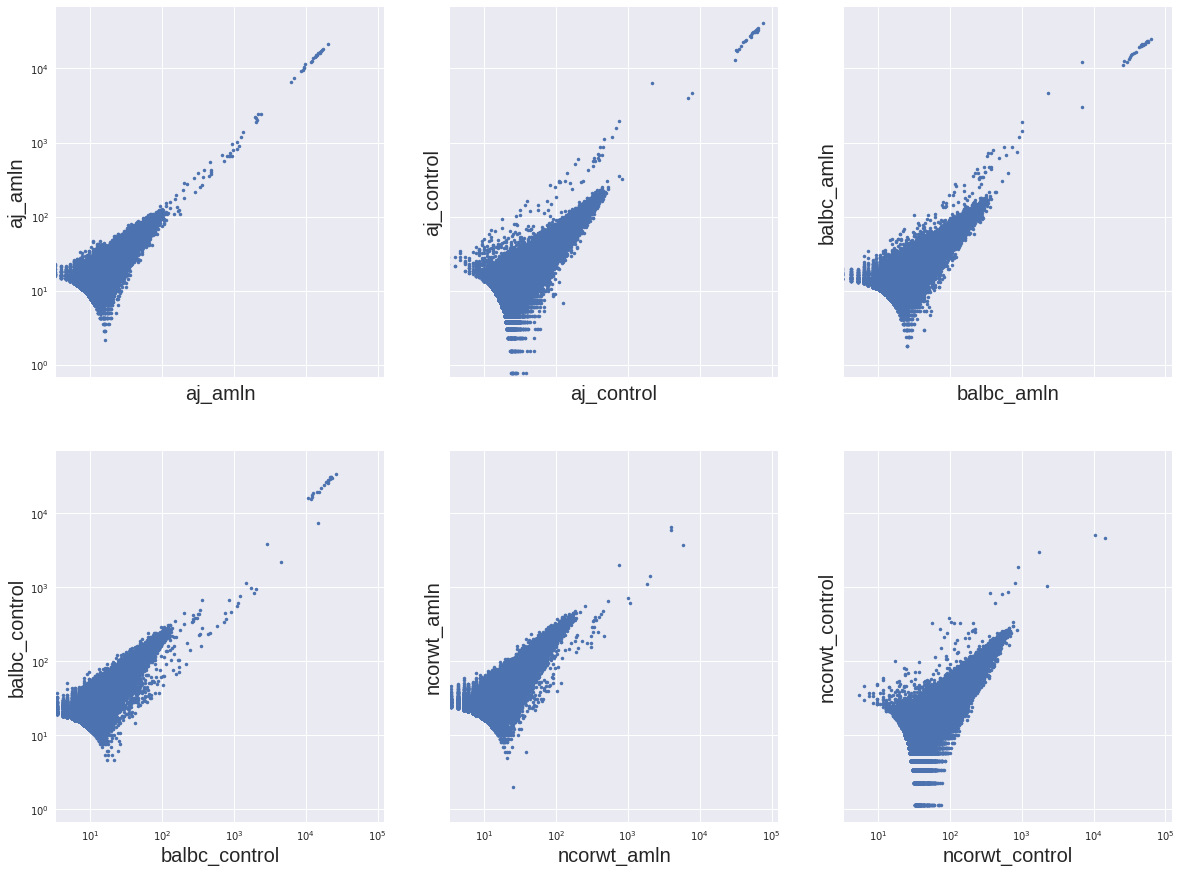

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,15),sharex=True, sharey=True)
for ax, i in zip(axs.reshape(-1), samplesDF.group.unique()):
    analysis = i.replace('-', '_')
    aP = outdir + analysis + '/optimal_peakfileAnno.txt'
    optPeaks = pd.read_csv(aP, sep='\t')
    ax.loglog(optPeaks.iloc[:, -2], optPeaks.iloc[:, -1], '.')
    ax.set_xlabel(i, fontsize=20)
    ax.set_ylabel(i, fontsize=20)

Start with analysis of balb peaks

merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/optimal_peakfile_merge.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/optimal_peakfile_merge_anno.txt already exists!
merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/optimal_peakfile_merge.txt already exists!
diff peaks file: /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/diffpeaks.txt already exists!
merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/optimal_peakfile_merge.txt already exists!
diff peaks file: /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/diffpeaks_rev.txt already exists!


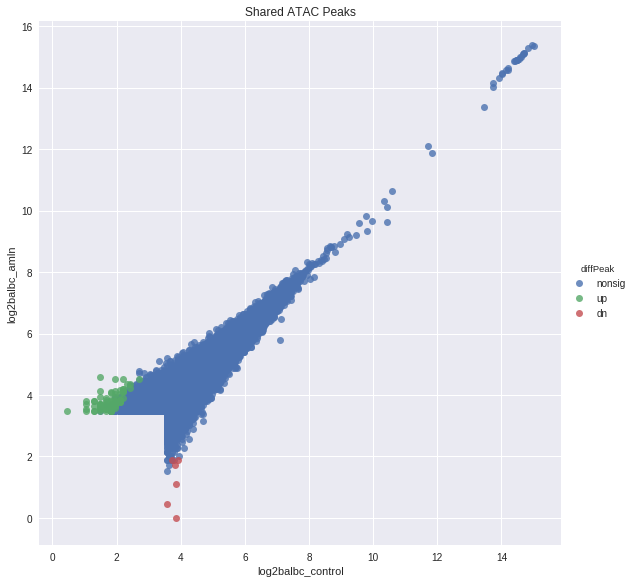

In [7]:
(balbc_peaks, balbc_dP, balbc_dPRev) = run_atac_diff_peaks(outdir + 'balbc_amln',
                                                        outdir + 'balbc_control',
                                                        outdir + 'balbc_amln',
                                                        dist='200',
                                                        print_err=True)

In [10]:
balbc_peaks.diffPeak.value_counts()

nonsig    42492
up          110
dn            6
Name: diffPeak, dtype: int64

#### run homer on the upregulated and downregulated peaks.

In [ ]:
find_motifs_genome(outdir+'balbc_amln/diffpeaks.txt',
                   genome='mm10',
                   outdir=outdir + 'balbc_amln/balbc_amln_increased_peaks/')
find_motifs_genome(outdir+'balbc_amln/diffpeaks_rev.txt',
                   genome='mm10',
                   outdir=outdir + 'balbc_amln/balbc_amln_increased_peaks/')

merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/optimal_peakfile_merge.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/optimal_peakfile_merge_anno.txt already exists!
merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/optimal_peakfile_merge.txt already exists!
diff peaks file: /home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/diffpeaks.txt already exists!
merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/optimal_peakfile_merge.txt already exists!
diff peaks file: /home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/diffpeaks_rev.txt already exists!


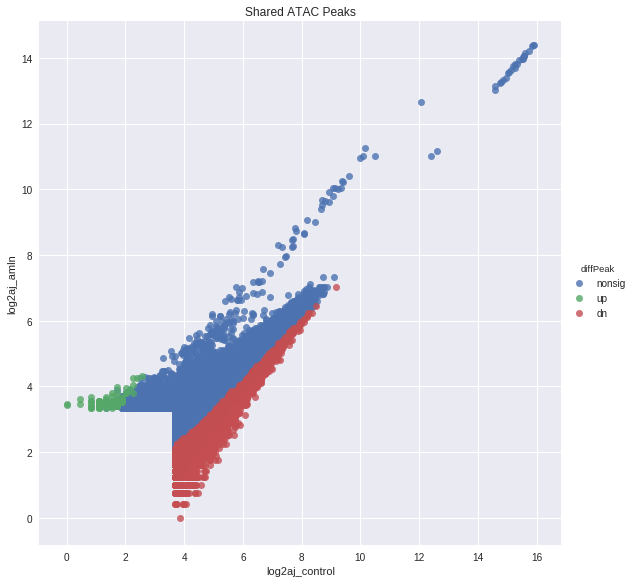

In [12]:
(aj_peaks, aj_dP, aj_dPRev) = run_atac_diff_peaks(outdir + 'aj_amln',
                                                  outdir + 'aj_control',
                                                  outdir + 'aj_amln',
                                                  dist='200',
                                                  print_err=True)

In [13]:
aj_peaks.diffPeak.value_counts()

nonsig    50254
dn         7534
up           76
Name: diffPeak, dtype: int64

In [ ]:
find_motifs_genome(outdir+'aj_amln/diffpeaks.txt',
                   genome='mm10',
                   outdir=outdir + 'aj_amln/aj_amln_increased_peaks/')
find_motifs_genome(outdir+'aj_amln/diffpeaks_rev.txt',
                   genome='mm10',
                   outdir=outdir + 'aj_amln/aj_amln_increased_peaks/')

merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/optimal_peakfile_merge.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/optimal_peakfile_merge_anno.txt already exists!
merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/optimal_peakfile_merge.txt already exists!
diff peaks file: /home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/diffpeaks.txt already exists!
merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/optimal_peakfile_merge.txt already exists!
diff peaks file: /home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/diffpeaks_rev.txt already exists!


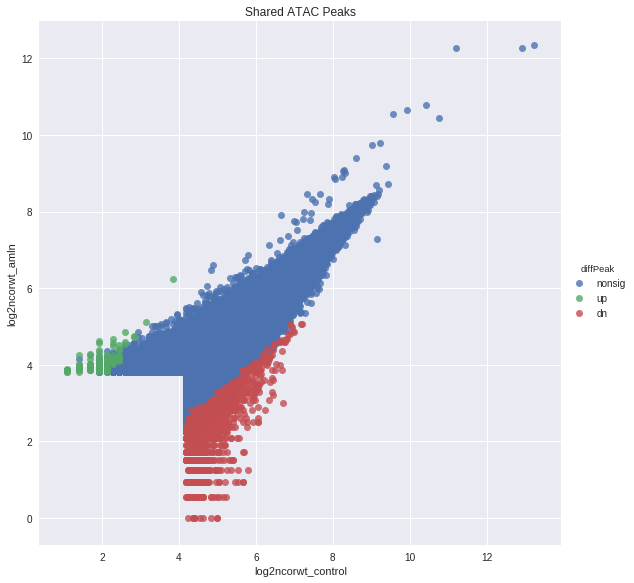

In [14]:
(ncorwt_peaks, ncorwt_dP, ncorwt_dPRev) = run_atac_diff_peaks(outdir + 'ncorwt_amln',
                                                              outdir + 'ncorwt_control',
                                                              outdir + 'ncorwt_amln',
                                                              dist='200',
                                                              print_err=True)

In [15]:
find_motifs_genome(outdir+'ncorwt_amln/diffpeaks.txt',
                   genome='mm10',
                   outdir=outdir + 'ncorwt_amln/ncorwt_amln_increased_peaks/')
find_motifs_genome(outdir+'ncorwt_amln/diffpeaks_rev.txt',
                   genome='mm10',
                   outdir=outdir + 'ncorwt_amln/ncorwt_amln_increased_peaks/')

calling homer...


KeyboardInterrupt: 

In [16]:
ncorwt_peaks.diffPeak.value_counts()

nonsig    55511
dn         1627
up          111
Name: diffPeak, dtype: int64

Next we want to overlay our ATAC and RNA Sequencing data to look for ATAC peaks associated with differential expression genes in AMLN vs Control

In [17]:
# load in files
deseq_dir = '/home/h1bennet/liverStrains/results/171208_RNA_Seq/'
# load in balbc deseq results
balbc_amln_deseq = pd.read_csv(deseq_dir + "/balbc_amln_deseq_results.txt")
balbc_amln_deseq.columns.values[0] = 'RepeatID'
balbc_amln_deseq = balbc_amln_deseq.set_index('RepeatID')
# load in ncorwt deseq results
ncorwt_amln_deseq = pd.read_csv(deseq_dir + "/ncorwt_amln_deseq_results.txt")
ncorwt_amln_deseq.columns.values[0] = 'RepeatID'
ncorwt_amln_deseq = ncorwt_amln_deseq.set_index('RepeatID')
# load in aj deseq results
aj_amln_deseq = pd.read_csv(deseq_dir + "/aj_amln_deseq_results.txt")
aj_amln_deseq.columns.values[0] = 'RepeatID'
aj_amln_deseq = aj_amln_deseq.set_index('RepeatID')

# load in rpkm file without adjustments
rpkm = pd.read_csv(deseq_dir + '/rnaseq_matrix_condenseGenes_exons_rpkm.txt', sep='\t')
rpkm.columns.values[0] = 'RepeatID'
rpkm = rpkm.set_index('RepeatID')

# drop the balb3A columns
to_drop = pd.Series(rpkm.columns).str.contains('Balb3a', flags=re.IGNORECASE)
to_drop[0] = False
rpkm= rpkm.loc[:, list(~to_drop)]

In [21]:
def btwn(x,y,z):
    # return True if y<=x<=z (x btwn y and z)
    return ((y<=x) & (x<=z))

def overlap_peak_rna(peaks, genes, dist=1, peak_string='unknown origin'):
    '''Look for peaks within 1Mb of the TSS
    Takes peak and gene file with the five columns
    in the HOMER format: ID (set as index), chr, start, end, strand
    in its current form it actually annotates the gene file that you feed into it'''
    dist = 1
    peak_list = []
    # iterate over chromosomes
    for ch in genes.chr.unique():
        chgenes = genes.loc[genes.chr==ch]
        chpeaks = peaks.loc[peaks.chr==ch]
        # print('%s genes and %s peaks on %s' % (chgenes.shape[0], chpeaks.shape[0], ch))
        # iterate over each entry from the gene set
        for index_g, row_g in chgenes.iterrows():
            # select any peak whose center is +/- Mb from TSS
            overlap = [index_p for index_p, row_p in chpeaks.iterrows()
                          if btwn((row_p.start + row_p.end)/2,
                                  row_g.start - dist*10**6,
                                  row_g.start + dist*10**6)]
            genes.loc[index_g, peak_string + ' peaks within ' + str(dist) + ' Mb'] = ', '.join(overlap)
            ## add to peak_list
            # if len(overlap) > 0:
                # peak_list.extend(overlap)

def melt_rpkm_diet(rpkm, sig=False):
    rpkm_m = pd.melt(rpkm)
    rpkm_m.value = np.log2(rpkm_m.value + 1)
    rpkm_m.loc[:, 'nearby_peak'] = [sig]*rpkm_m.shape[0]
    rpkm_m.loc[:, 'diet'] = rpkm_m.variable.str\
                .extract('_([a-zA-Z]*)Diet_', expand=False)
    return rpkm_m

def plot_rna_near_peaks(deseq, dist=1, strain='', peak_string=''):
    import scipy.stats
    rpkm_sig = hbUtils.df_col_subset(
            deseq.loc[deseq.nearby_peak!='',:], '.*'+strain+'.*Kupffer.*')
    rpkm_nonsig = hbUtils.df_col_subset(
            deseq.loc[deseq.nearby_peak=='',:], '.*'+strain+'.*Kupffer.*')
    
    # melt and combine the sig and nonsig
    rpkm_m = pd.concat([melt_rpkm_diet(rpkm_sig, sig=True),
                       melt_rpkm_diet(rpkm_nonsig, sig=False)])
    
    # create sub-axis for plotting
    f, axarr = plt.subplots(2, 2, figsize=[15,10])
    
    # plot RPKM boxplots within 1 Mb of differential peak
    sns.boxplot(x='diet', y='value',
                data=rpkm_m.loc[rpkm_m.nearby_peak==True, :],
                ax=axarr[0,0])
    axarr[0,0].set_title('RPKM %sMb near %s' % (dist, peak_string))
    (rho, p) = scipy.stats.ranksums(rpkm_m.loc[(rpkm_m.nearby_peak==True) & (rpkm_m.diet=='AMLN'), 'value'],
                                   rpkm_m.loc[(rpkm_m.nearby_peak==True) & (rpkm_m.diet=='Control'), 'value'])
    axarr[0,0].text(.5, 0.9, "p = %.5f" % p, fontsize=9,
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=axarr[0,0].transAxes)
    # plot RPKM boxplots of expression >1 Mb away differential peak
    sns.boxplot(x='diet', y='value',
                data=rpkm_m.loc[rpkm_m.nearby_peak==False, :],
                ax=axarr[0,1])
    axarr[0,1].set_title('RPKM >%sMb from %s' % (dist, peak_string))
    (rho, p) = scipy.stats.ranksums(rpkm_m.loc[(rpkm_m.nearby_peak==False) & (rpkm_m.diet=='AMLN'), 'value'],
                                   rpkm_m.loc[(rpkm_m.nearby_peak==False) & (rpkm_m.diet=='Control'), 'value'])
    axarr[0,1].text(.5, 0.9, "p = %.5f" % p, fontsize=9,
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=axarr[0,1].transAxes)
    # plot histograms of expression within 1 Mb of differential peak
    sns.distplot(rpkm_m.loc[(rpkm_m.nearby_peak==True) & (rpkm_m.diet=='AMLN'), 'value'],
                ax=axarr[1,0])
    sns.distplot(rpkm_m.loc[(rpkm_m.nearby_peak==True) & (rpkm_m.diet=='Control'), 'value'],
                ax=axarr[1,0])
    axarr[1,0].set_title('RPKM %sMb near %s' % (dist, peak_string))
    # plot histograms of expression >1 Mb away differential peak
    sns.distplot(rpkm_m.loc[(rpkm_m.nearby_peak==False) & (rpkm_m.diet=='AMLN'), 'value'],
                ax=axarr[1,1])
    sns.distplot(rpkm_m.loc[(rpkm_m.nearby_peak==False) & (rpkm_m.diet=='Control'), 'value'],
                ax=axarr[1,1])
    axarr[1,1].set_title('RPKM >%sMb from %s' % (dist, peak_string))

    
    
    # plot the counts as a boxplot
    # sns.factorplot(x='diet', y='value',
    #                col='nearby_peak',
    #                data=rpkm_m, kind='box')


def analyze_peak_rna(peaks, amln_deseq, rpkm, dist=1,
                     strain='', peak_string='unknown origin'):
    # copy over data frames
    peaks = peaks.copy(deep=True)
    amln_deseq = amln_deseq.copy(deep=True)
    amln_deseq = amln_deseq.merge(rpkm,
            left_index=True,
            right_index=True)
    
    # select significant getDifferentialPeaks
    sig_peaks = peaks.loc[peaks.diffPeak != 'nonsig', :].iloc[:, 0:4]
    # select genes with padj <0.05 and FC > 2 by DESeq2
    sig_genes = amln_deseq\
                .loc[(amln_deseq.padj <= 0.05) & (np.abs(amln_deseq.log2FoldChange) >= 1), :]\
                .iloc[:, 6:10]
            
    # adjust names for input into function
    sig_peaks.columns = ['chr', 'start', 'end', 'strand']
    sig_genes.columns = ['chr', 'start', 'end', 'strand']
    sig_peaks['ucsc'] = sig_peaks.apply(
            lambda x: x['chr'] + ':%s-%s' % (x['start'], x['end']), axis=1)
    
    # overlap peaks
    print("finding peaks within %sMb of gene set..." % (dist))
    overlap_peak_rna(sig_peaks, sig_genes, dist=dist, peak_string=peak_string)
        
    # annotate the balb_amln_deseq RNA information with nearby peak information
    amln_deseq['nearby_peak'] = sig_genes.iloc[:, -1]
    amln_deseq.loc[amln_deseq.nearby_peak.isnull(), 'nearby_peak'] = ''
    
    # melt and process for plotting
    plot_rna_near_peaks(amln_deseq, dist=dist, strain=strain, peak_string=peak_string)
    
    return(sig_peaks, amln_deseq)

def get_distal_peaks(peaks, flag='intergenic'):
    peaks.to_csv(outdir + 'pk.tmp', sep='\t')
    gDP = ['getDistalPeaks.pl', outdir + 'pk.tmp', 'mm10', '-' + flag]
    print('running bash command: ' + ' '.join(gDP))
    p = subprocess.Popen(gDP,
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE)
    out, err = p.communicate()
    print('done!')
    print('importing results...')
    f = open(outdir + 'pk.dist.tmp', 'w')
    f.write(out.decode('utf-8'))
    f.close()
    peaks_distal = pd.read_csv(outdir + 'pk.dist.tmp', sep='\t')
    print('done!')
    print('removing tmp files...')
    subprocess.call(['rm', outdir+'pk.tmp'])
    subprocess.call(['rm', outdir+'pk.dist.tmp'])
    print('done!')
    return peaks.loc[peaks_distal.iloc[:, 0], :]

### AJ Differential Peaks

finding peaks within 1Mb of gene set...


/home/h1bennet/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


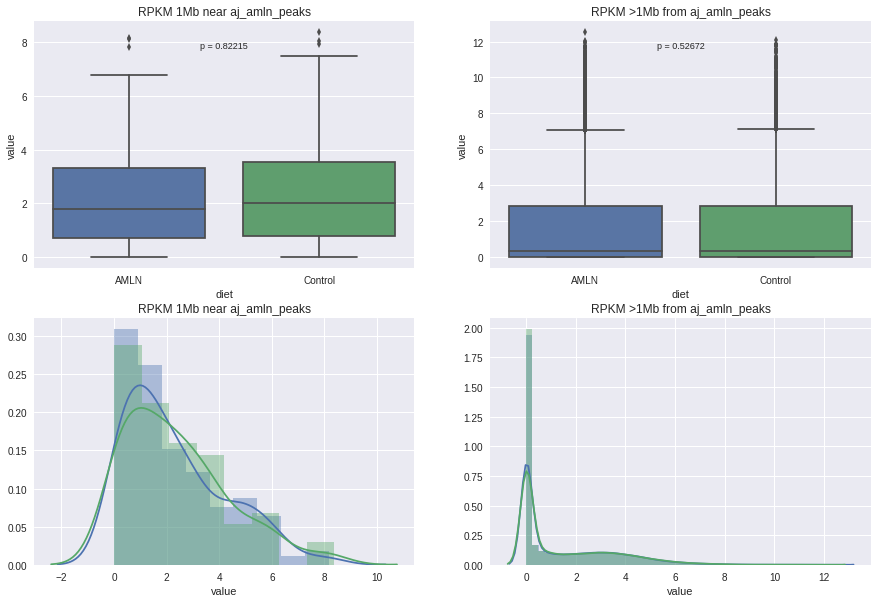

In [22]:
p, a = analyze_peak_rna(aj_peaks, aj_amln_deseq, rpkm, peak_string='aj_amln_peaks', strain='aj')

running bash command: getDistalPeaks.pl /home/h1bennet/liverStrains/results/171212_ATAC/pk.tmp mm10 -intergenic
done!
importing results...
done!
removing tmp files...
done!
finding peaks within 1Mb of gene set...


/home/h1bennet/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


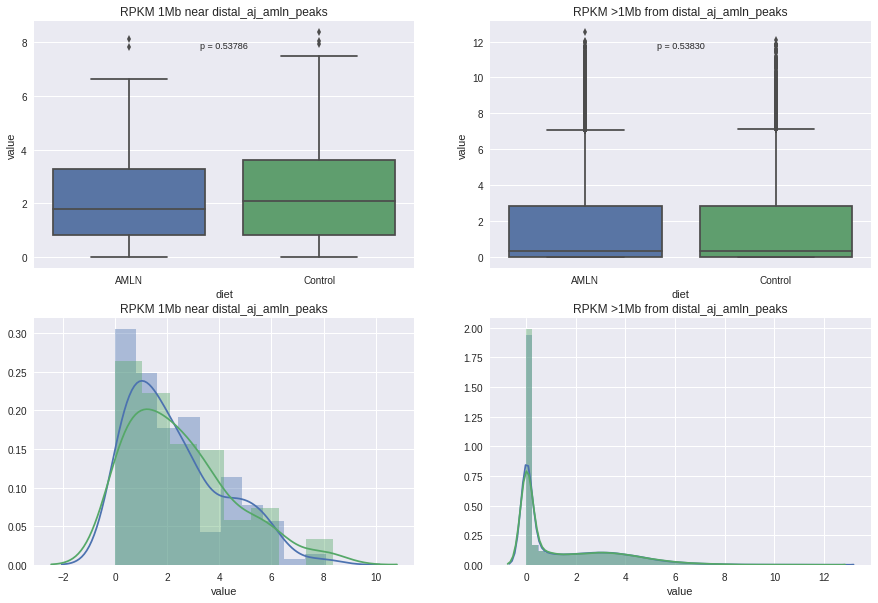

In [23]:
aj_peaks_dist = get_distal_peaks(aj_peaks)
p, a = analyze_peak_rna(aj_peaks_dist, aj_amln_deseq, rpkm, peak_string='distal_aj_amln_peaks', strain='aj')

### BALBc Differential Peaks 

finding peaks within 1Mb of gene set...


/home/h1bennet/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


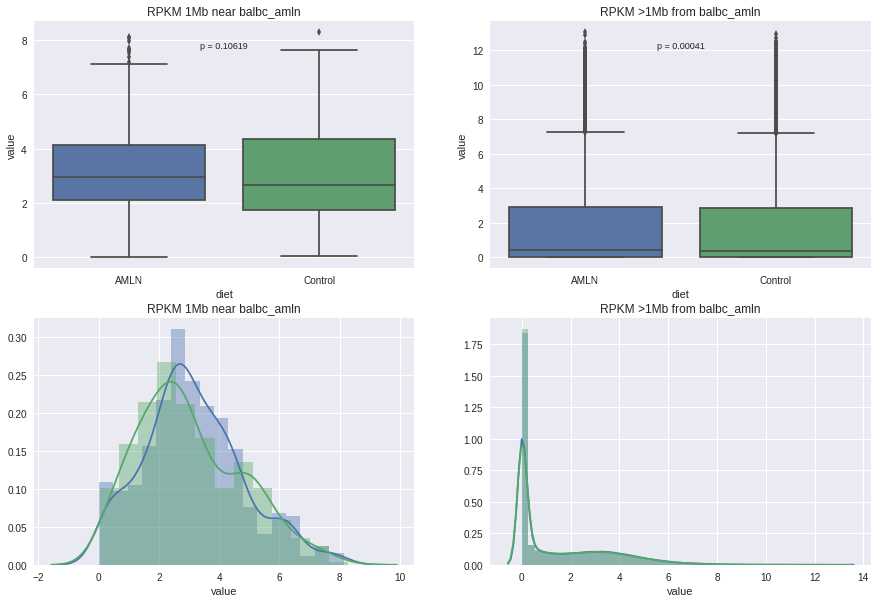

In [24]:
p, a = analyze_peak_rna(balbc_peaks, balbc_amln_deseq, rpkm, peak_string='balbc_amln')

running bash command: getDistalPeaks.pl /home/h1bennet/liverStrains/results/171212_ATAC/pk.tmp mm10 -intergenic
done!
importing results...
done!
removing tmp files...
done!
finding peaks within 1Mb of gene set...


/home/h1bennet/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


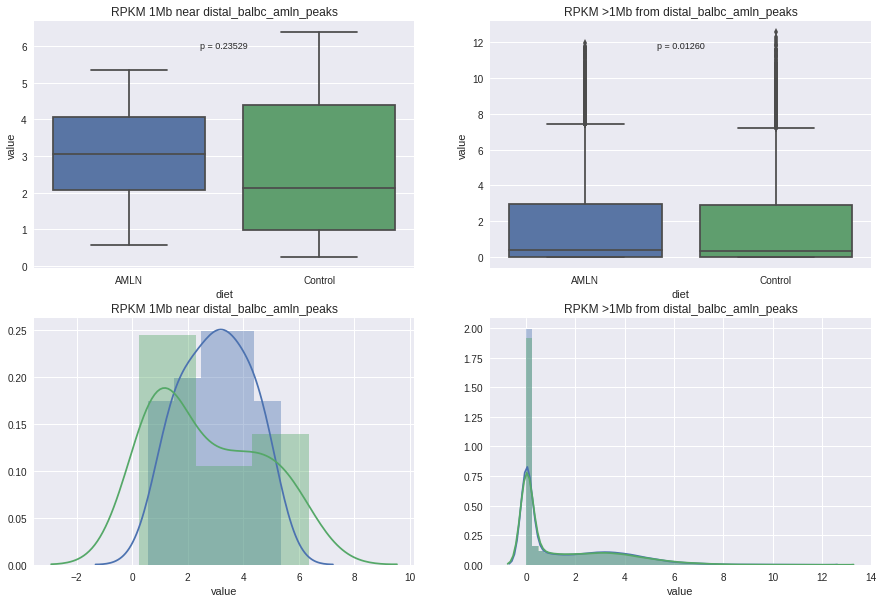

In [25]:
balbc_peaks_dist = get_distal_peaks(balbc_peaks)
p, a = analyze_peak_rna(balbc_peaks_dist, balbc_amln_deseq, rpkm, peak_string='distal_balbc_amln_peaks', strain='balbc')

### NCoRWT peaks 

finding peaks within 1Mb of gene set...


/home/h1bennet/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


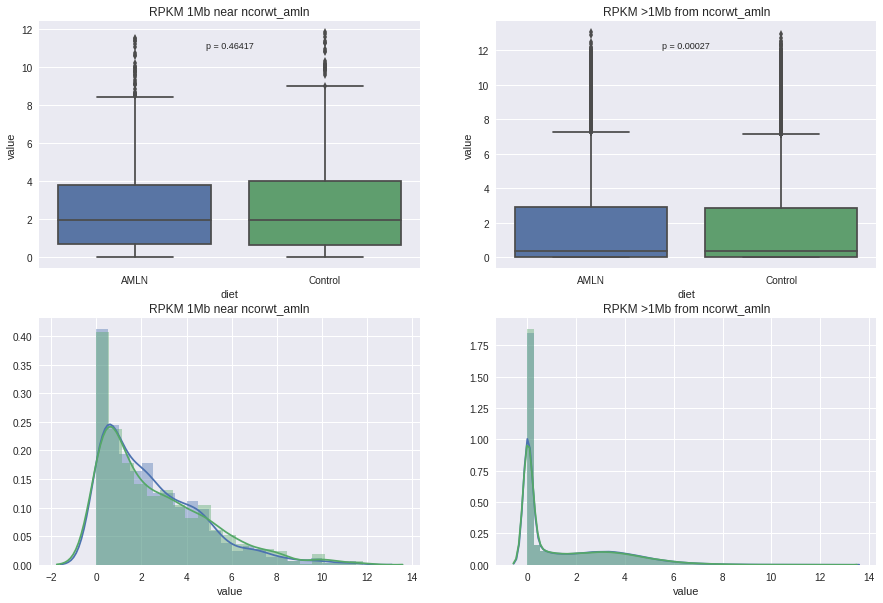

In [26]:
p, a = analyze_peak_rna(ncorwt_peaks, ncorwt_amln_deseq, rpkm, peak_string='ncorwt_amln')

running bash command: getDistalPeaks.pl /home/h1bennet/liverStrains/results/171212_ATAC/pk.tmp mm10 -intergenic
done!
importing results...
done!
removing tmp files...
done!
finding peaks within 1Mb of gene set...


/home/h1bennet/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


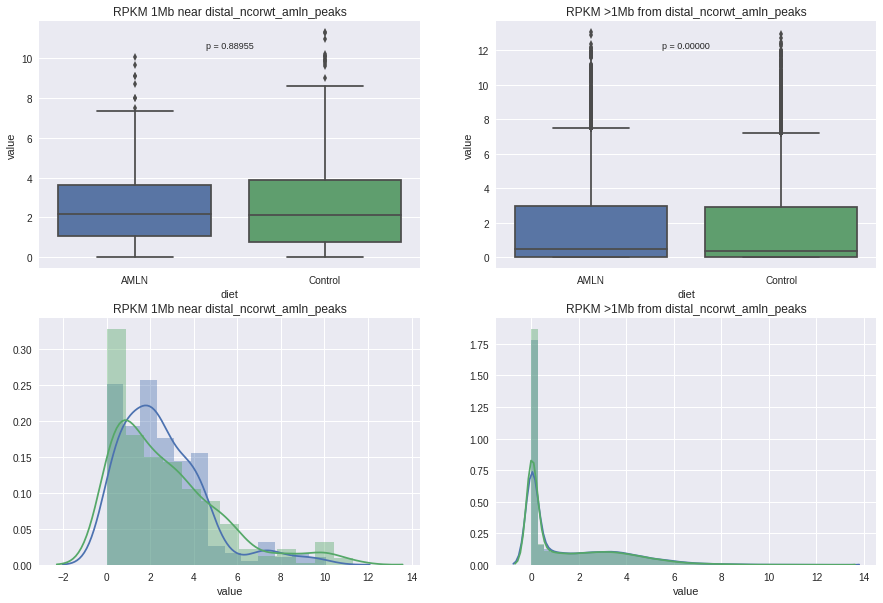

In [27]:
ncorwt_peaks_dist = get_distal_peaks(ncorwt_peaks)
p, a = analyze_peak_rna(ncorwt_peaks_dist, ncorwt_amln_deseq, rpkm, peak_string='distal_ncorwt_amln_peaks', strain='ncorwt')

### We also want to look more closely at genes that are strain specific as determined by the deseq model 
Do they have nearby ATAC peaks that are also strain specific?

One strategy for calling strain specific ATAC peaks is to call peaks with the amln sample in the foreground and all the other samples in the background. We 

* (done) get strain specific differential diet induced peaks
* overlap the peaks from one strain with all the peaks from the other two strains
    * can use the -prefix option for merge peaks in this case
* could also just look for peaks that do NOT overlap with upregulated peaks in the other two strains...

In [28]:
ncorwt_peaks.head()

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type,"/home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/pooled_tag_dirs Tag Count in given bp (21558302.0 Total, normalization factor = 0.46, effective total = 10000000)","/home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_control/pooled_tag_dirs Tag Count in given bp (18035425.0 Total, normalization factor = 0.55, effective total = 10000000)",diffPeak,log2ncorwt_amln,log2ncorwt_control
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr1-24612753-2,chr1,24612653,24612853,+,7389.549805,/home/h1bennet/liverStrains/results/171212_ATA...,Intergenic,Intergenic,-25316.0,NM_007733,...,ENSMUSG00000026141,Col19a1,-,"collagen, type XIX, alpha 1",protein-coding,5180.83,9598.33,nonsig,12.339246,13.228718
Merged-chr1-24613116-2,chr1,24613016,24613217,+,6367.950195,/home/h1bennet/liverStrains/results/171212_ATA...,Intergenic,Intergenic,-25679.0,NM_007733,...,ENSMUSG00000026141,Col19a1,-,"collagen, type XIX, alpha 1",protein-coding,4931.28,7804.64,nonsig,12.268039,12.930301
Merged-chr2-98667194-2,chr2,98667093,98667296,+,3627.350098,/home/h1bennet/liverStrains/results/171212_ATA...,Intergenic,GSAT_MM|Satellite|Satellite,1199537.0,NM_178725,...,ENSMUSG00000050587,Lrrc4c,6430556C10Rik|NGL-1,leucine rich repeat containing 4C,protein-coding,4884.89,2369.78,nonsig,12.254406,11.211146
Merged-chr2-98662360-2,chr2,98662257,98662463,+,1555.300049,/home/h1bennet/liverStrains/results/171212_ATA...,Intergenic,GSAT_MM|Satellite|Satellite,1194703.0,NM_178725,...,ENSMUSG00000050587,Lrrc4c,6430556C10Rik|NGL-1,leucine rich repeat containing 4C,protein-coding,1746.43,1365.65,nonsig,10.771019,10.416428
Merged-chrUn_JH584304-59717-2,chrUn_JH584304,59611,59823,+,1496.750000,/home/h1bennet/liverStrains/results/171212_ATA...,promoter-TSS (NR_003518),promoter-TSS (NR_003518),-28.0,NR_003518,...,NaN,Pisd-ps3,4933439C20Rik,"phosphatidylserine decarboxylase, pseudogene 3",pseudo,1392.50,1733.81,nonsig,10.444497,10.760562


#### As a first pass for differential peaks lets take a look at diff peaks that are unique to each strain...
Using the merge peaks -prefix argument we can output both overlapping and unique peaks to separate files.

In [30]:
' '.join(['mergePeaks', '-d', '200', '-prefix tst',
          outdir + 'balbc_amln/diffpeaks_rev.txt', outdir + 'aj_amln/diffpeaks_rev.txt',
          outdir + 'ncorwt_amln/diffpeaks_rev.txt'])

'mergePeaks -d 200 -prefix tst /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/diffpeaks_rev.txt /home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/diffpeaks_rev.txt /home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/diffpeaks_rev.txt'

In [31]:
' '.join(['mergePeaks', '-d', '200', '-prefix tst', outdir + 'balbc_amln/diffpeaks.txt',
        outdir + 'aj_amln/diffpeaks.txt', outdir + 'ncorwt_amln/diffpeaks.txt'])

'mergePeaks -d 200 -prefix tst /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/diffpeaks.txt /home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/diffpeaks.txt /home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/diffpeaks.txt'

In [49]:
aj_balb = pd.read_csv(outdir + "tst__home_h1bennet_liverStrains_results_171212_ATAC_balbc_amln_diffpeaks.txt__home_h1bennet_liverStrains_results_171212_ATAC_aj_amln_diffpeaks_rev.txt", sep='\t')

In [52]:
aj_balb

,#name (cmd = mergePeaks -d 200 -prefix tst /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/diffpeaks.txt /home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/diffpeaks.txt /home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/diffpeaks.txt /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/diffpeaks_rev.txt /home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/diffpeaks_rev.txt /home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/diffpeaks_rev.txt),chr,start,end,strand,Stat,Parent files,Total subpeaks,/home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/diffpeaks.txt,/home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/diffpeaks.txt,/home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/diffpeaks.txt,/home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/diffpeaks_rev.txt,/home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/diffpeaks_rev.txt,/home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/diffpeaks_rev.txt
0,Merged-chr1-151661156-2,chr1,151661047,151661266,+,14.700000,/home/h1bennet/liverStrains/results/171212_ATA...,2,Merged-chr1-151661147-1,NaN,NaN,NaN,Merged-chr1-151661166-1,NaN
1,Merged-chr8-34805219-2,chr8,34805090,34805349,+,16.100000,/home/h1bennet/liverStrains/results/171212_ATA...,2,Merged-chr8-34805190-1,NaN,NaN,NaN,Merged-chr8-34805249-1,NaN
2,Merged-chr13-16912434-2,chr13,16912319,16912550,+,23.150002,/home/h1bennet/liverStrains/results/171212_ATA...,2,Merged-chr13-16912419-1,NaN,NaN,NaN,Merged-chr13-16912450-1,NaN
3,Merged-chr16-50364834-2,chr16,50364729,50364939,+,13.550000,/home/h1bennet/liverStrains/results/171212_ATA...,2,Merged-chr16-50364829-1,NaN,NaN,NaN,Merged-chr16-50364839-1,NaN
4,Merged-chr15-58046760-2,chr15,58046657,58046863,+,18.900000,/home/h1bennet/liverStrains/results/171212_ATA...,2,Merged-chr15-58046763-1,NaN,NaN,NaN,Merged-chr15-58046757-1,NaN
5,Merged-chr8-78889901-2,chr8,78889801,78890001,+,15.700000,/home/h1bennet/liverStrains/results/171212_ATA...,2,Merged-chr8-78889901-1,NaN,NaN,NaN,Merged-chr8-78889901-1,NaN
6,Merged-chr2-24910689-2,chr2,24910570,24910808,+,14.150000,/home/h1bennet/liverStrains/results/171212_ATA...,2,Merged-chr2-24910670-1,NaN,NaN,NaN,Merged-chr2-24910708-1,NaN
7,Merged-chr19-59028085-2,chr19,59027974,59028197,+,15.500000,/home/h1bennet/liverStrains/results/171212_ATA...,2,Merged-chr19-59028074-1,NaN,NaN,NaN,Merged-chr19-59028097-1,NaN


In [ ]:
# subset only peaks that were significant when called using getDifferentialPeaks
balbc_sig_peaks = balbc_peaks.loc[balbc_peaks.diffPeak != 'nonsig', :].iloc[:, 0:4]
# subset only genes that were called significant with FC > 2 by DESeq2
balbc_sig_genes = balbc_amln_deseq\
            .loc[(balbc_amln_deseq.padj <= 0.05) & (np.abs(balbc_amln_deseq.log2FoldChange) >= 1), :]\
            .iloc[:, 6:10]
# adjust names for input into function
balbc_sig_peaks.columns = ['chr', 'start', 'end', 'strand']
balbc_sig_genes.columns = ['chr', 'start', 'end', 'strand']
balbc_sig_peaks['ucsc'] = balbc_sig_peaks.apply(lambda x: x['chr'] + ':%s-%s' % (x['start'], x['end']),axis=1)

In [51]:
overlap_peak_rna(aj_peaks, aj_amln_deseq, peak_string='aj_amln_diff_peaks')

AttributeError: 'DataFrame' object has no attribute 'chr'

In [ ]:
analyze_peak_rna

In [43]:
balbc_sig_peaks.head()

,chr,start,end,strand,ucsc
PeakID,,,,,
Merged-chr6-71373667-1,chr6,71373567,71373767,+,chr6:71373567-71373767
Merged-chr8-122139968-1,chr8,122139868,122140068,+,chr8:122139868-122140068
Merged-chr9-75195866-1,chr9,75195766,75195966,+,chr9:75195766-75195966
Merged-chr8-64726297-1,chr8,64726197,64726397,+,chr8:64726197-64726397
Merged-chr1-130918797-1,chr1,130918697,130918897,+,chr1:130918697-130918897


In [25]:
# annotate the balb_amln_deseq RNA information with nearby peak information
balbc_amln_deseq['nearby_peak'] = balbc_sig_genes.iloc[:, -1]
balbc_amln_deseq.loc[balbc_amln_deseq.nearby_peak.isnull(), 'nearby_peak'] = ''

In [40]:
balbc_amln_rpkm_sig = hbUtils.df_col_subset(
        balbc_amln_deseq.loc[balbc_amln_deseq.nearby_peak!='',:],
        '.*balb.*Kupffer.*')
melt_rpkm(balbc_amln_rpkm_sig).head()

,variable,value,nearby_peak,diet
0,/data/mm10/Kupffer/RNA/balbc_KupfferTotal_RNA_...,0.388465,True,AMLN
1,/data/mm10/Kupffer/RNA/balbc_KupfferTotal_RNA_...,2.806530,True,AMLN
2,/data/mm10/Kupffer/RNA/balbc_KupfferTotal_RNA_...,0.891419,True,AMLN
3,/data/mm10/Kupffer/RNA/balbc_KupfferTotal_RNA_...,1.829038,True,AMLN
4,/data/mm10/Kupffer/RNA/balbc_KupfferTotal_RNA_...,2.846794,True,AMLN


                                            variable     value nearby_peak  \
0  /data/mm10/Kupffer/RNA/balbc_KupfferTotal_RNA_...  0.388465        True   
1  /data/mm10/Kupffer/RNA/balbc_KupfferTotal_RNA_...  2.806530        True   
2  /data/mm10/Kupffer/RNA/balbc_KupfferTotal_RNA_...  0.891419        True   
3  /data/mm10/Kupffer/RNA/balbc_KupfferTotal_RNA_...  1.829038        True   
4  /data/mm10/Kupffer/RNA/balbc_KupfferTotal_RNA_...  2.846794        True   

   diet  
0  AMLN  
1  AMLN  
2  AMLN  
3  AMLN  
4  AMLN  


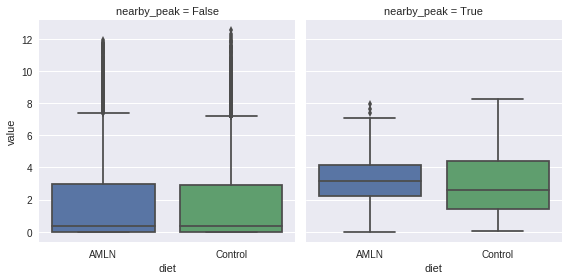

In [41]:
plot_rna_near_peaks(balbc_amln_deseq, strain='balb')

In [674]:
# plot the average expression of genes within balb kupffer near diff peaks and far from them
balbc_amln_rpkm_sig = hbUtils.df_col_subset(balbc_amln_deseq.loc[balbc_amln_deseq.nearby_peak!='',:], '.*balb.*Kupffer.*')
balbc_amln_rpkm_sig = pd.melt(balbc_amln_rpkm_sig)
balbc_amln_rpkm_sig.value = np.log2(balbc_amln_rpkm_sig.value + 1)
balbc_amln_rpkm_sig.loc[:, 'nearby_peak'] = [True] * balbc_amln_rpkm_sig.shape[0]
balbc_amln_rpkm_sig.loc[:, 'diet'] = balbc_amln_rpkm_sig.variable.str.extract('_([a-zA-Z]*)Diet_', expand=False)

balbc_amln_rpkm_nonsig = hbUtils.df_col_subset(balbc_amln_deseq.loc[balbc_amln_deseq.nearby_peak=='',:], '.*balb.*Kupffer.*')
balbc_amln_rpkm_nonsig = pd.melt(balbc_amln_rpkm_nonsig)
balbc_amln_rpkm_nonsig.value = np.log2(balbc_amln_rpkm_nonsig.value + 1)
balbc_amln_rpkm_nonsig.loc[:, 'nearby_peak'] = [False] * balbc_amln_rpkm_nonsig.shape[0]
balbc_amln_rpkm_nonsig.loc[:, 'diet'] = balbc_amln_rpkm_nonsig.variable.str.extract('_([a-zA-Z]*)Diet_', expand=False)

balbc_amln_rpkm = pd.concat([balbc_amln_rpkm_sig, balbc_amln_rpkm_nonsig])

In [42]:
balbc_amln_rpkm.head()

NameError: name 'balbc_amln_rpkm' is not defined

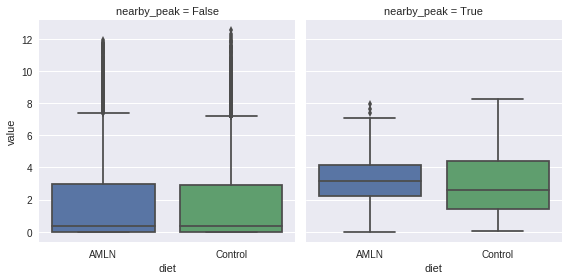

In [677]:
sns.factorplot(x='diet', y='value', col='nearby_peak', data=balbc_amln_rpkm, kind='box')